# Solving and Simulating a DSGE Model using the LinApp Package in Python

### by [Kerk L. Phillips](https://sites.google.com/site/kerkphillips/home), July 2018

The code in this Jupyter notebook was written using Python 3.6.

This notebook explains how to set up a DSGE model and solve it in Python using the linearization techniques implemented in the LinApp package.  This package can be downloaded at the following Github site.  [https://github.com/kerkphil/DSGE-Utilities](https://github.com/kerkphil/DSGE-Utilities).  Alternatively, both those files and this notebook can be found in the public GitHub repository [https://github.com/kerkphil/Jupyter_Notebooks](https://github.com/kerkphil/Jupyter_Notebooks).

The LinApp package includes the following files:

LinApp_FindSS - Takes a function, funcname.py, and a steady state value for the exogenous state variables as inputs.  Finds the steady state for the model's endogenous state and jump variables.

LinApp_Deriv - Takes a function, funcname.py, as an input.   Generates the derivative matrices needed for the Uhlig toolkit.

LinApp_Solve - Takes the derivative matrices as inputs.  Uses the code from the Uhlig toolkit to generate the coefficients for the linearized policy function(s).

LinApp_Sim - Takes the policy function coefficients and current state as inputs.  Generates the value(s) of the endogenous state variables for the next period.

LinApp_SSL - Takes a history of exogenous state variables and the policy function coefficients as inputs.  Generates a history of state and jump variables using linearization about the steady state.

We begin by writing down the behavioral equations for a simple DSGE model.

We use the following definitions:

$k_t$ is the capital stock in period $t$.

$z_t$ is the percent deviation of technology from its long-run value.

$r_t$ is the rental rate on capital.

$w_t$ is the wage rate.

$c_t$ is private consumption.

$i_t$ is investment.

$\varepsilon_t$ is the random innovation to $z_t$

We also have the following parameters:
$\alpha$ is the capital share in GDP.

$\beta$ is the subjective discount factor.

$\gamma$ is the curvature of the utility function.  In our example this is the constant elasticity of intertemporal substitition.  It is also the constant coefficient of relative risk aversion.

$\delta$ is the rate of capital depreciation.

$\rho$ is the autocorrelation of $z_t$.

$\sigma$ is the standard deviation of the $\varepsilon_t$ shocks.

Suppose the household's Bellman equation is given by:
$$ V(k_t, z_t) = \max_{k_{t+1}} \frac{c_t^{1-\gamma}-1}{1-\gamma} + \beta V(k_{t+1}, z_{t+1}) $$

$$ c_t = w_t + (1+r_t-\delta)k_t - k_{t+1} $$

The first-order condition is:
$$ c_t^{-\gamma} = \beta V_k(k_{t+1}, z_{t+1}) $$
The envelope condition is:
$$ \beta V_k(k_t, z_t) = c_t^{-\gamma}(1+r_t-\delta) $$
Combining give the Euler equation:
$$ c_t^{-\gamma} = \beta c_{t+1}^{-\gamma}(1+r_{t+1}-\delta) $$

From the firm's problem we have the following:
$$ y_t = k_t^\alpha e^{(1-\alpha)z_t} $$
$$ r_t = \alpha \frac{y_t}{k_t} $$
$$ w_t = (1-\alpha)y_t $$

Finally, we assume the following law of motion for $ z_t $:
$$ z_t = \rho z_{t-1} + \varepsilon_t; \varepsilon_t \sim iid(0,\sigma^2) $$

## Programming Definitions Functions

We want to write a function, $\Gamma(X_{t+1}, X_t, X_{t-1}, Y_{t+1}, Y_t, Z_{t+1}, Z_t) = 0 $ based on the Euler equation.  We will define our set of endogenous state variables as $X_t = k_{t+1}$, $Y_t = \emptyset$, and $Z_t = z_t$.

First we can define $y_t, r_t, w_t$ and $c_t$ as functions of the state $(k_t, z_t)$ using the budget constraint and the conditions from the firm's problem.  The parameters of the model, $\alpha, \beta, \gamma, \delta, \rho, \& \sigma$, are included in the Python list `mparams`.

$$ y_t = k_t^\alpha e^{(1-\alpha)z_t} $$
$$ r_t = \alpha \frac{y_t}{k_t} $$
$$ w_t = (1-\alpha)y_t $$
$$ c_t = w_t + (1+r_t-\delta)k_t - k_{t+1} $$
$$ i_t = y_t - c_t $$
$$ u_t = \frac{c_t^{1-\gamma}-1}{1-\gamma} $$

In [1]:
def modeldefs(Xm, Xn, Z, *mparams):
    # unpack sets
    k = Xm                            # k(t-1)
    kp = Xn                           # k(t)
    z = Z                             # z(t)
    # find variables
    y = k**alpha*np.exp((1-alpha)*z)  # y(t)
    r = alpha*y/k                     # r(t)
    w = (1-alpha)*y                   # w(t)
    c = w + (1+r-delta)*k - kp        # c(t)
    i = y - c                         # i(t)
    if gamma == 1.0:                  # u(t)
        u = np.log(c)
    else:
        u = (c**(1-gamma)-1)/(1-gamma)
    if np.isnan(u) or np.isinf(u):
        u = -1.0E+99
    return y, r, w, c, i, u

Next we define our $\Gamma$ function which is simply the Euler equation rewritten.
$$ \Gamma = c_t^{-\gamma} - \beta c_{t+1}^{-\gamma} (1+r_{t+1}-\delta) $$


In [2]:
def Gamma(invec, *mparams):
    # unpack input vector
    kpp = invec[0]    # k(t+2)
    kp = invec[1]     # k(t+1)
    k = invec[2]      # k(t)
    zp = invec[3]     # z(t+1)
    z = invec[4]      # z(t)
    # find period t values
    y, r, w, c, i, u = modeldefs(k, kp, z, *mparams)
    # find period t+1 values
    yp, rp, wp, cp, ip, up = modeldefs(kp, kpp, zp, *mparams)
    # calculate Euler equation (Gamma function)
    Gamma = c**(-gamma) - beta*(cp)**(-gamma)*(1+rp-delta)
    return Gamma

The advantage of writing the code with two functions is that we only need to code the definitions once.  We call that function twice, but we minimize the number of functions we need to code.  An alternative would be to use the following single function.


In [3]:
def Gamma2(invec, *mparams):
    # unpack sets
    kpp = invec[0]    # k(t+2)
    kp = invec[1]     # k(t+1)
    k = invec[2]      # k(t)
    zp = invec[3]     # z(t+1)
    z = invec[4]      # z(t)
    # find period t values
    y = k**alpha*np.exp((1-alpha)*z)    # y(t)
    r = alpha*y/k                       # r(t)
    w = (1-alpha)*y                     # w(t)
    c = w + (1+r-delta)*k - kp          # c(t)
    i = y - c                           # i(t)
    if gamma == 1.0:                  # u(t)
        u = np.log(c)
    else:
        u = (c**(1-gamma)-1)/(1-gamma)
    if np.isnan(u) or np.isinf(u):
        u = -1.0E+99
    # find period t+1 values
    yp = kp**alpha*np.exp((1-alpha)*zp) # y(t+1)
    rp = alpha*yp/kp                    # r(t+1)
    wp = (1-alpha)*yp                   # w(t+1)
    cp = wp + (1+rp-delta)*kp - kpp     # c(t+1)
    ip = yp - cp                        # i(t+1)
    if gamma == 1.0:                  # u(t)
        up = np.log(cp)
    else:
        up = (cp**(1-gamma)-1)/(1-gamma)
    if np.isnan(u) or np.isinf(u):
        up = -1.0E+99
    # calculate Euler equation (Gamma function)
    Gamma = beta*(c/cp)**(gamma)*(1+rp-delta)
    return Gamma

However, using the function below requires making changes to each defitional function twice if we have made a coding error or if we change the model.  In addition, the definitions function is useful by itself for finding steady state and simulation values for y, r, w, c and i.

## Writing the Main Program

Now we can write a program that will solve and simulate our model.
First we need to call the Python packages and files we need.

In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.optimize as opt
from LinApp_FindSS import LinApp_FindSS
from LinApp_Deriv import LinApp_Deriv
from LinApp_Solve import LinApp_Solve
from LinApp_SSL import LinApp_SSL

Next we set our parameter values.

In [5]:
alpha = .33
beta = .95
gamma = 2.5
delta = .08
rho = .9
sigma = .02
mparams = (alpha, beta, gamma, delta, rho, sigma)

### Finding the Steady State

To find the steady state we use LinApp_FindSS.

This function takes the form - LinApp_FindSS(funcname, param, guessXY, Zbar, nx, ny), where funcname will be "Gamma", param will be "mparams", guessXY will be scalar guess for the value of kbar, Zbar is 0, nx is 1, and ny is 0.  The output is XYbar, which will just be kbar in our case.  guessXY and Zbar need to be numpy arrays.


In [6]:
# find the steady state
guessXY = np.array([1.])
zbar = np.array([0.])
XYbar = LinApp_FindSS(Gamma, mparams, guessXY, zbar, 1, 0)
kbar = XYbar[0]
# check solution works
invec = np.array([kbar, kbar, kbar, 0., 0.])
check = Gamma(invec, *mparams)
print('kbar: ', kbar)
print('check:', check)

kbar:  3.8980397970046137
check: 0.0


We can get the steady states for all the other variables using our definintions function

In [7]:
ybar, rbar, wbar, cbar, ibar, ubar = modeldefs(kbar, kbar, zbar, *mparams)
print('ybar: ', ybar)
print('rbar: ', rbar)
print('wbar: ', wbar)
print('cbar: ', cbar)
print('ibar: ', ibar)
print('ubar: ', ubar)

ybar:  [1.56667628]
rbar:  [0.13263158]
wbar:  [1.04967311]
cbar:  [1.2548331]
ibar:  [0.31184318]
ubar:  [0.19239215]


### Solving for the Policy Function Parameters

The next step is to find the derivatives of the Gamma function and then use these to solve for the coefficients of the linear policy function.  This requires using LinApp_Deriv and LinApp_Solve.

We linearize or log-linearize the $\Gamma(X_{t+1}, X_t, X_{t-1}, Y_{t+1}, Y_t, Z_{t+1}, Z_t) = 0 $ function about the steady state to get the following approximations.

$$ A \tilde X_{t} + B\tilde X_{t-1} + C \tilde Y_{t} + D \tilde Z_{t} = 0$$

$$E_t\left\{F \tilde X_{t+1} + G \tilde X_{t} + H \tilde X_{t-1} + J \tilde Y_{t+1} + K \tilde Y_{t} + L \tilde Z_{t+1} + M \tilde Z_{t} \right\}= 0$$

The top equation approximates the equation(s) defining any jump variables, while the bottom one approximates the equations(s) defining the endogenous state variable(s).

Since we have no jump variables, we can ignore the top equation and write the bottom one as:

$$E_t\left\{F \tilde X_{t+1} + G \tilde X_{t} + H \tilde X_{t-1} + L \tilde Z_{t+1} + M \tilde Z_{t} \right\}= 0$$

The linearized policy and jump functions are given by:

$$\tilde X_{t} = P \tilde X_{t-1} + Q \tilde Z_{t}$$

$$\tilde Y_{t} = R \tilde X_{t-1} + S \tilde Z_{t}$$

Note that $\tilde X_{t}$ is $X_{t} - \bar X$ if we are simply linearizing, and is $\frac{X_{t} - $X_{t} - \bar X$}{$X_{t} - \bar X}$ if we are log-linearizing.  The `LinApp_Deriv` function has an option that takes the appropriate derivatives.


In [8]:
# find derivatives of Gamma

# set the options for LinApp_Deriv
nx = 1  # number of X variables
ny = 0  # number of Y variables
nz = 1  # number of Z variables
takelogs = False  # if True the model is log-linearized, otherwise simple linearization

[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM] = \
    LinApp_Deriv(Gamma, mparams, invec, nx, ny, nz, takelogs)

# set the options for LinApp_Solve
Sylv = False  # if True use Python's built-in Sylvester equation solver, otherwise us the code in LinApp_Solve

# NN is the autoregressive parameter in z's law of motion
NN = rho
# solve for coefficients
PP, QQ, RR, SS = \
    LinApp_Solve(AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, NN, zbar, Sylv)
print('PP:',PP)
print('QQ', QQ)


PP: [[0.92276239]]
QQ [[0.59443154]]


### Simulating the Model

Finally we simulate our model using LinApp_SSL

This function takes the form - LinApp_SSL(X0, Z, XYbar, logX, PP, QQ, RR, SS), where X0 is the starting value and Z is a numpy array containing a history of Z's generated using the law of motion.  Both Z and kbar must be 2-dimensional numpy arrays.


In [9]:
# generate a history of Z's
T = 1000  # number of observations to generate
# initialize Z
zhist = np.zeros((T,1))
# generate a history of epsilon shocks with mean zero and variance sigma-squared
epshist = np.random.randn(T,1)*sigma
# iteratively generate Z's starting with the first value of Z = 0
for t in range (1,T):
    zhist[t,:] = rho*zhist[t-1,:] + epshist[t,:]
# generate a history of k's
kbar2 = np.array([[kbar]])
khist, temp = LinApp_SSL(kbar2, zhist, kbar2, takelogs, PP, QQ, RR, SS)

With a history of k's and z's we have a history of all our state variables.  We can use our definitions function to get the histories of all the other variables.

In [10]:
# initialize histories of all other variables
yhist = np.zeros(T)
rhist = np.zeros(T)
whist = np.zeros(T)
chist = np.zeros(T)
ihist = np.zeros(T)
uhist = np.zeros(T)
# set initial values noting we started at the steady state
yhist[0] = ybar
rhist[0] = rbar
whist[0] = wbar
chist[0] = cbar
ihist[0] = ibar
uhist[0] = ubar
# compute values for all other time periods
for t in range(1, T-1):
    yhist[t], rhist[t], whist[t], chist[t], ihist[t], uhist[t] = \
        modeldefs(khist[t-1], khist[t], zhist[t,:], *mparams)

Lastly we can plot our simulated data

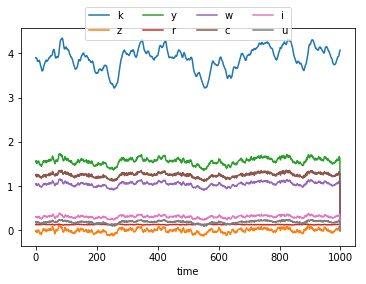

In [11]:
# plot data
t = range(0, T)
plt.plot(t, khist, label='k')
plt.plot(t, zhist, label='z')
plt.plot(t, yhist, label='y')
plt.plot(t, rhist, label='r')
plt.plot(t, whist, label='w')
plt.plot(t, chist, label='c')
plt.plot(t, ihist, label='i')
plt.plot(t, uhist, label='u')
plt.xlabel('time')
plt.legend(loc=9, ncol=4, bbox_to_anchor=(0., 1.02, 1., .102))
plt.show()